In [ ]:
!pip uninstall numpy matplotlib -y
!pip install --force-reinstall --no-deps matplotlib==3.8.2
!pip install numpy matplotlib

In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [13]:
def get_data(pde_name, pde_params, metrics, extension, entity_name):
    proj_name = f'{pde_name}_{extension}'
    data = {}

    api = wandb.Api()
    best_l2re = float('inf')
    best_run = None
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue

        config = run.config
        if config['pde_params'] != pde_params:
            continue

        l2re = run.summary["test/l2re"]
        if l2re < best_l2re:
            best_l2re = l2re
            best_run = run

    # Retrieve optimizer switch points
    adam_to_lbfgs_iter = int(best_run.config['opt_params'][6])
    lbfgs_to_nncg_iter = int(best_run.config['opt_params'][8])

    lbfgs_to_nncg_iter = int(lbfgs_to_nncg_iter - adam_to_lbfgs_iter) + int(adam_to_lbfgs_iter / 20)
    adam_to_lbfgs_iter = int(adam_to_lbfgs_iter / 20)

    for metric in metrics:
        data[metric] = best_run.history(samples=int(1e6), keys=[metric], pandas=False)
        data[metric] = [dict[metric] for dict in data[metric]]

        # Include optimizer switch points in data
        data[f'{metric}_switches'] = [adam_to_lbfgs_iter, lbfgs_to_nncg_iter]

    return data

In [14]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    if pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [27]:
def plot_under_optimize_multi_pde(pdes, metrics, extension, entity_name, metric_names, opt_colors,
                                  font_size, folder_path, filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4)) # Adjust figsize as needed

    for col, (pde_name, pde_params) in enumerate(pdes):
        data = get_data(pde_name, pde_params, metrics, extension, entity_name)

        for row, metric in enumerate(metrics):
            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])

            # Retrieve optimizer switch points
            switches = data[f'{metric}_switches']
            adam_to_lbfgs_iter, lbfgs_to_nncg_iter = switches

            # Plotting segments with different colors
            ax.plot(data[metric][:adam_to_lbfgs_iter], color=opt_colors['adam'], label='Adam')
            ax.plot(range(adam_to_lbfgs_iter, lbfgs_to_nncg_iter), data[metric][adam_to_lbfgs_iter:lbfgs_to_nncg_iter], color=opt_colors['lbfgs'], label='L-BFGS')
            ax.plot(range(lbfgs_to_nncg_iter, len(data[metric])), data[metric][lbfgs_to_nncg_iter:], color=opt_colors['nncg'], label='NNCG')

            ax.set_title(get_title(pde_name, pde_params))
            ax.set_xlabel('Iterations / 20')
            ax.set_ylabel(metric_names[metric])
            ax.set_yscale('log')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [28]:
entity_name = 'sketchy-opts'
extension = 'adam_lbfgs_nncg_best'
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'nncg': 'tab:pink'
}
metric_names = {
    'loss': 'Loss',
    'grad_norm': 'Gradient Norm'
}

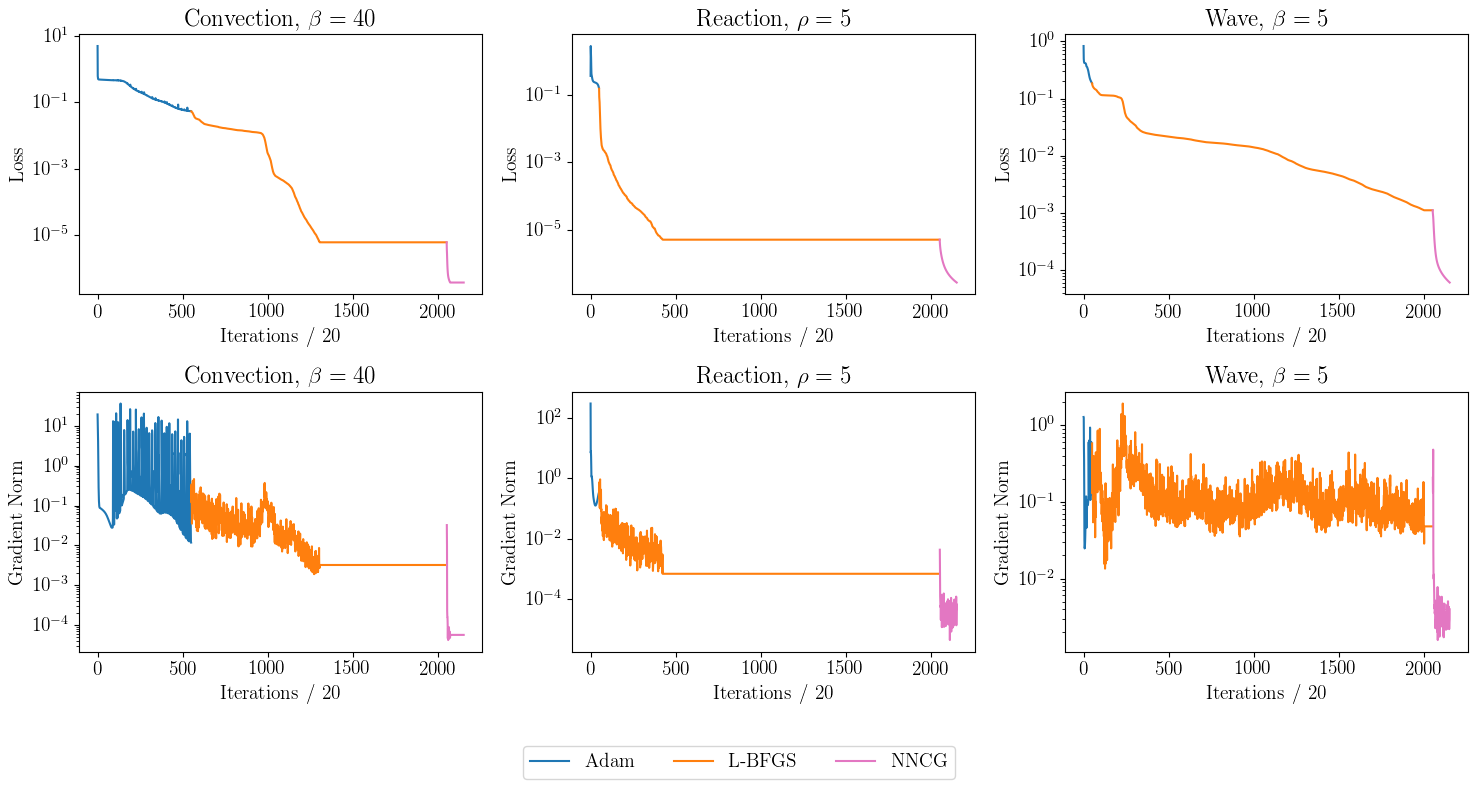

In [29]:
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'grad_norm']
folder_path = 'under_optimization_plots'
filename = 'under_optimization'

plot_under_optimize_multi_pde(pdes, metrics, extension, entity_name, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)